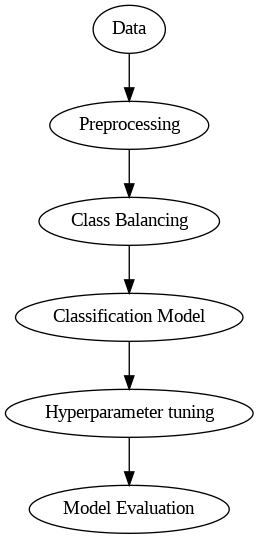

In [ ]:
# Diagrama de flujo simplificado del proceso de clasificación y ajuste de hiperparámetros

from graphviz import Digraph

dot = Digraph(comment='Proceso de Clasificación')
dot.node('A', 'Data')
dot.node('B', 'Preprocessing')
dot.node('C', 'Class Balancing')
dot.node('D', 'Classification Model')
dot.node('E', 'Hyperparameter tuning')
dot.node('F', 'Model Evaluation')

dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])
dot.render('proceso_clasificacion', format='png', cleanup=True)
from IPython.display import Image
Image(filename='proceso_clasificacion.png')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

file_path = '/content/sample_data/expanded_bug_commit_dataset.csv'
df = pd.read_csv(file_path, delimiter=',')


df = df[(df['bug_type'] != 'KeyError') & (df['bug_type'] != 'AttributeError')]


In [ ]:
# Convertir todas las columnas relevantes a float después de reemplazar comas por puntos en las columnas de texto
columns_to_convert = ['complexity', 'num_lines', 'num_functions', 'maintainability_index',
                      'num_classes', 'avg_function_length', 'nesting_levels', 'num_imports', 'num_comments']

for col in columns_to_convert:
    # Solo aplicar .str.replace si la columna es de tipo texto
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col].str.replace(',', '.', regex=True), errors='coerce')
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df['avg_num_parameters'] = df['avg_num_parameters'].str.replace(',', '.', regex=True).astype(float)


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   commit_sha                20000 non-null  object 
 1   filename                  20000 non-null  object 
 2   maintainability_index     15976 non-null  float64
 3   complexity                15976 non-null  float64
 4   num_lines                 15976 non-null  float64
 5   num_functions             15976 non-null  float64
 6   num_classes               15976 non-null  float64
 7   avg_function_length       15976 non-null  float64
 8   avg_num_parameters        15976 non-null  float64
 9   nesting_levels            15976 non-null  float64
 10  num_comments              15976 non-null  float64
 11  duplicated_code_warnings  15976 non-null  float64
 12  num_imports               15976 non-null  float64
 13  cyclic_dependencies       15976 non-null  float64
 14  is_bug

In [ ]:
print(df.describe())

       maintainability_index    complexity     num_lines  num_functions  \
count           1.597600e+04  15976.000000  15976.000000   15976.000000   
mean            1.086179e+16    192.309652   1607.275163      61.127566   
std             1.595191e+16    235.633502   2274.935698      71.824029   
min             0.000000e+00      0.000000      0.000000       0.000000   
25%             1.000000e+02     38.000000    323.000000      14.000000   
50%             4.365395e+15    106.000000    807.000000      33.000000   
75%             1.072680e+16    260.000000   2022.000000      85.000000   
max             7.898310e+16   1178.000000  13983.000000     667.000000   

        num_classes  avg_function_length  avg_num_parameters  nesting_levels  \
count  15976.000000         1.597600e+04        1.597600e+04    15976.000000   
mean       4.698610         7.929467e+15        9.736206e+15        7.958813   
std       15.079005         1.343911e+16        1.029832e+16        5.236664   
min 

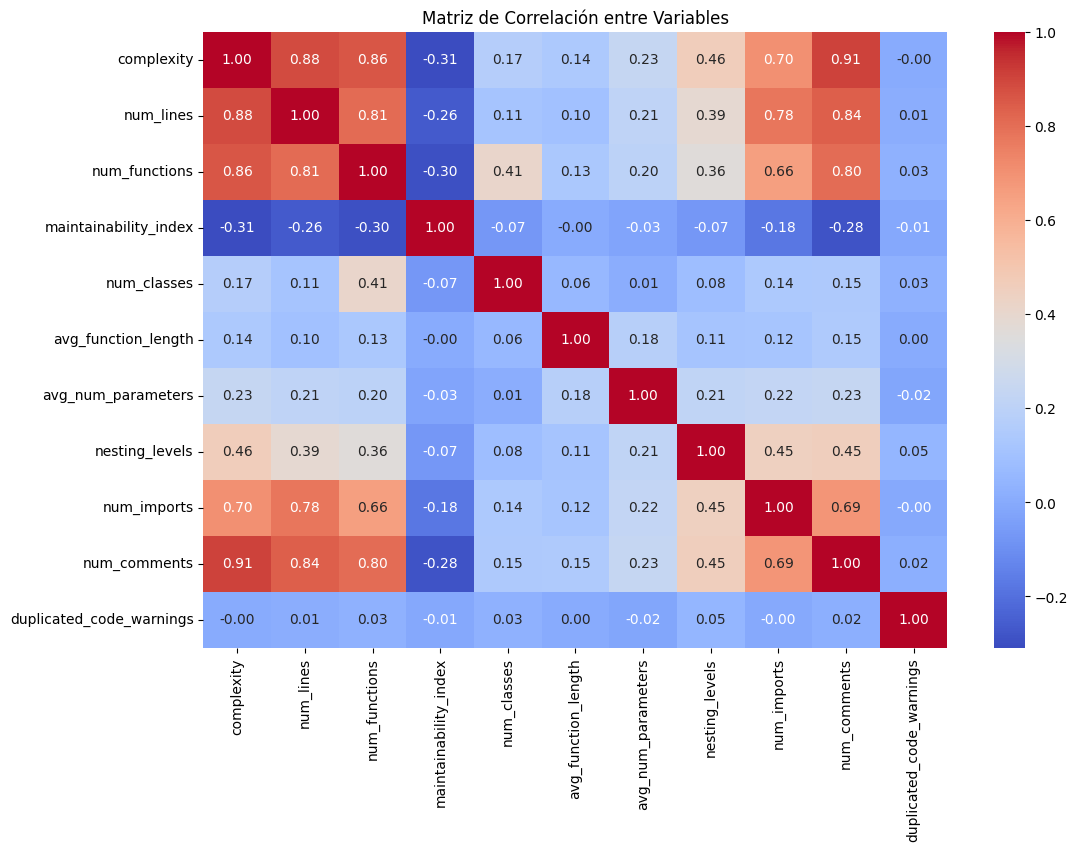

In [ ]:
# Diagrama de correlación entre variables
plt.figure(figsize=(12, 8))
correlation_matrix = df[['complexity', 'num_lines', 'num_functions', 'maintainability_index',
                         'num_classes', 'avg_function_length','avg_num_parameters', 'nesting_levels', 'num_imports', 'num_comments','duplicated_code_warnings']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre Variables')
plt.show()

**Correlaciones Altas:**

num_lines y num_functions tienen una correlación extremadamente alta (0.91), lo que sugiere que a medida que aumenta el número de líneas, también tiende a aumentar el número de funciones. Esto puede deberse a que proyectos más grandes y complejos generalmente contienen más funciones.

complexity y num_lines muestran una correlación alta (0.83), lo cual es intuitivo ya que un código más extenso en términos de líneas probablemente sea más complejo.

maintainability_index tiene una correlación negativa fuerte con complexity (-0.76), num_lines (-0.78) y num_functions (-0.68). Esto se debe a que un índice de mantenibilidad más alto suele indicar código más fácil de mantener, lo que normalmente implica menor complejidad y tamaño.

num_comments está positivamente correlacionado con complexity (0.71), num_lines (0.78) y num_functions (0.62). Esto sugiere que, a medida que aumenta la complejidad o el tamaño del código, también tienden a aumentar los comentarios, posiblemente para facilitar su comprensión.

**Correlaciones Moderadas:**

num_imports tiene una correlación moderada con num_lines (0.54) y num_comments (0.58). Esto podría indicar que, en proyectos más grandes, es necesario importar más dependencias o librerías, lo cual se refleja en un mayor número de importaciones.

num_classes muestra una correlación moderada con num_functions (0.60) y num_lines (0.56), lo cual sugiere que proyectos que contienen más clases también tienden a tener más funciones y líneas de código.

**Correlaciones Bajas:**

avg_function_length tiene bajas correlaciones con casi todas las variables, lo cual indica que la longitud promedio de las funciones no depende directamente de la cantidad de funciones, clases, o la complejidad general del código.

nesting_levels muestra bajas correlaciones con la mayoría de las variables, lo que sugiere que la profundidad de anidamiento no varía significativamente en función de otras métricas del código.

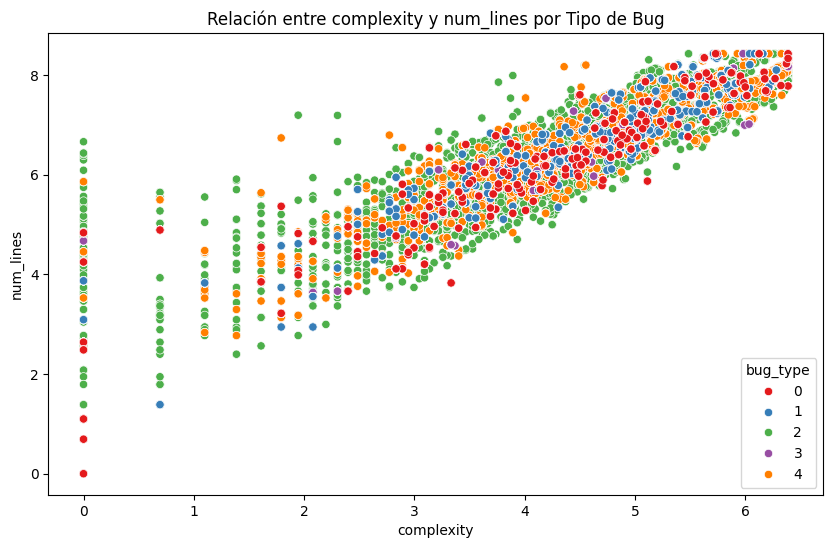

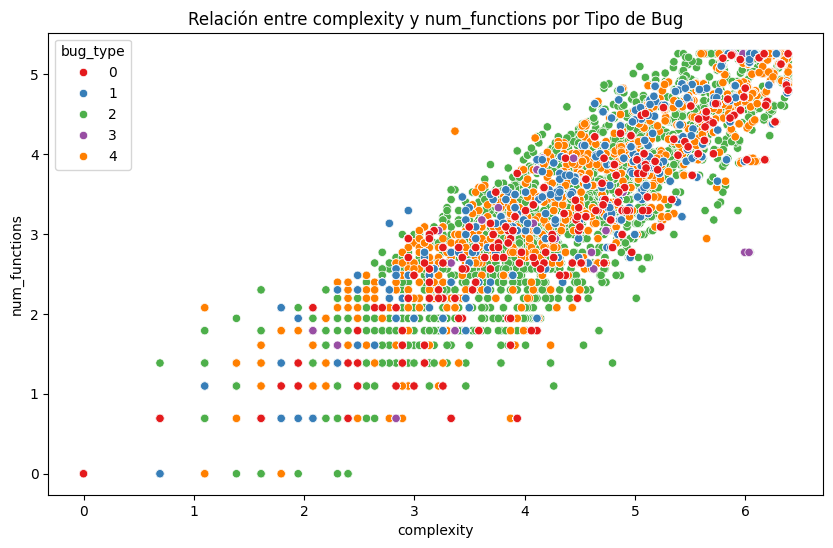

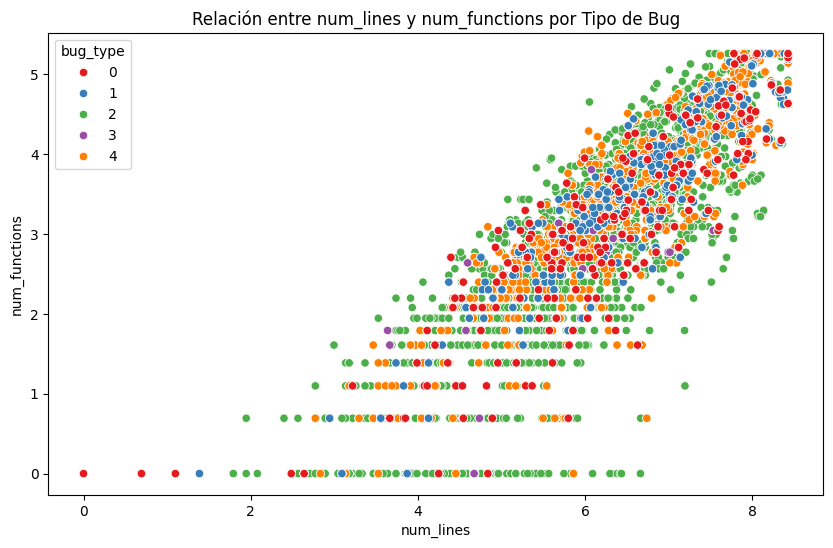

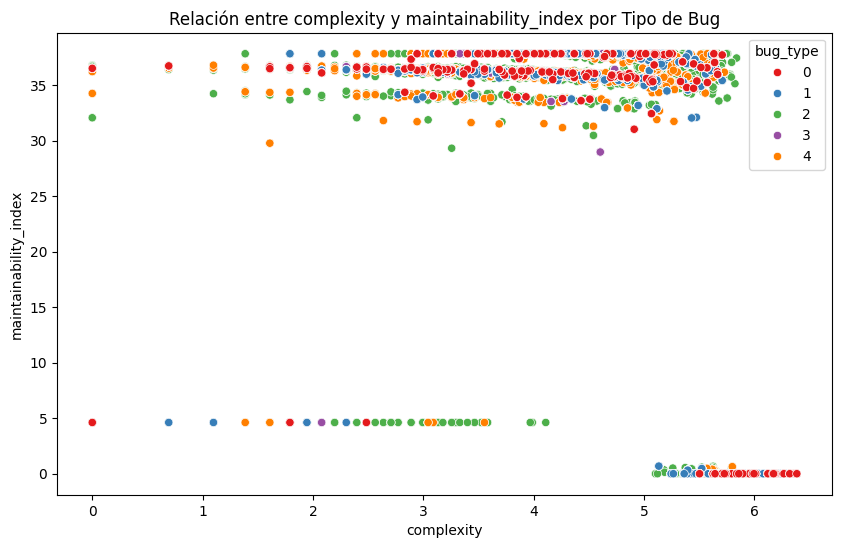

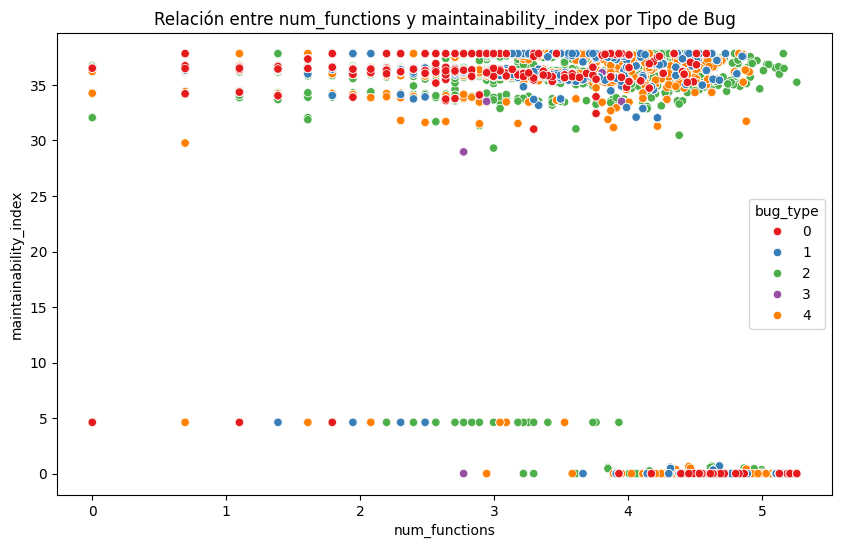

In [ ]:
# Relación entre Complejidad y otras métricas por tipo de bug
metrics_pairs = [
    ('complexity', 'num_lines'),
    ('complexity', 'num_functions'),
    ('num_lines', 'num_functions'),
    ('complexity', 'maintainability_index'),
    ('num_functions', 'maintainability_index')
]

# Graficar múltiples pares de variables
for metric_x, metric_y in metrics_pairs:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=metric_x, y=metric_y, hue='bug_type', palette="Set1")
    plt.title(f"Relación entre {metric_x} y {metric_y} por Tipo de Bug")
    plt.show()

#PROCESAMIENTO DE OUTLIERS

In [ ]:
# Crear una copia del DataFrame original para comparar antes y después
df_original = df.copy()

# Lista de variables en las que queremos procesar outliers
variables_to_impute_outliers = [
    'num_lines', 'num_functions', 'complexity', 'maintainability_index',
    'avg_function_length', 'avg_num_parameters', 'num_classes', 'nesting_levels', 'num_comments', 'num_imports'
]


In [ ]:
# Función para recortar outliers usando el IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Aplicar el procesamiento de outliers a las variables seleccionadas
for feature in variables_to_process_outliers:
    df = remove_outliers_iqr(df, feature)

NameError: name 'variables_to_process_outliers' is not defined

In [ ]:
# Función para imputar outliers usando el IQR
def impute_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Reemplazar los outliers con el límite inferior o superior según corresponda
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

# Aplicar la imputación de outliers a las variables seleccionadas
for feature in variables_to_impute_outliers:
    impute_outliers_iqr(df, feature)



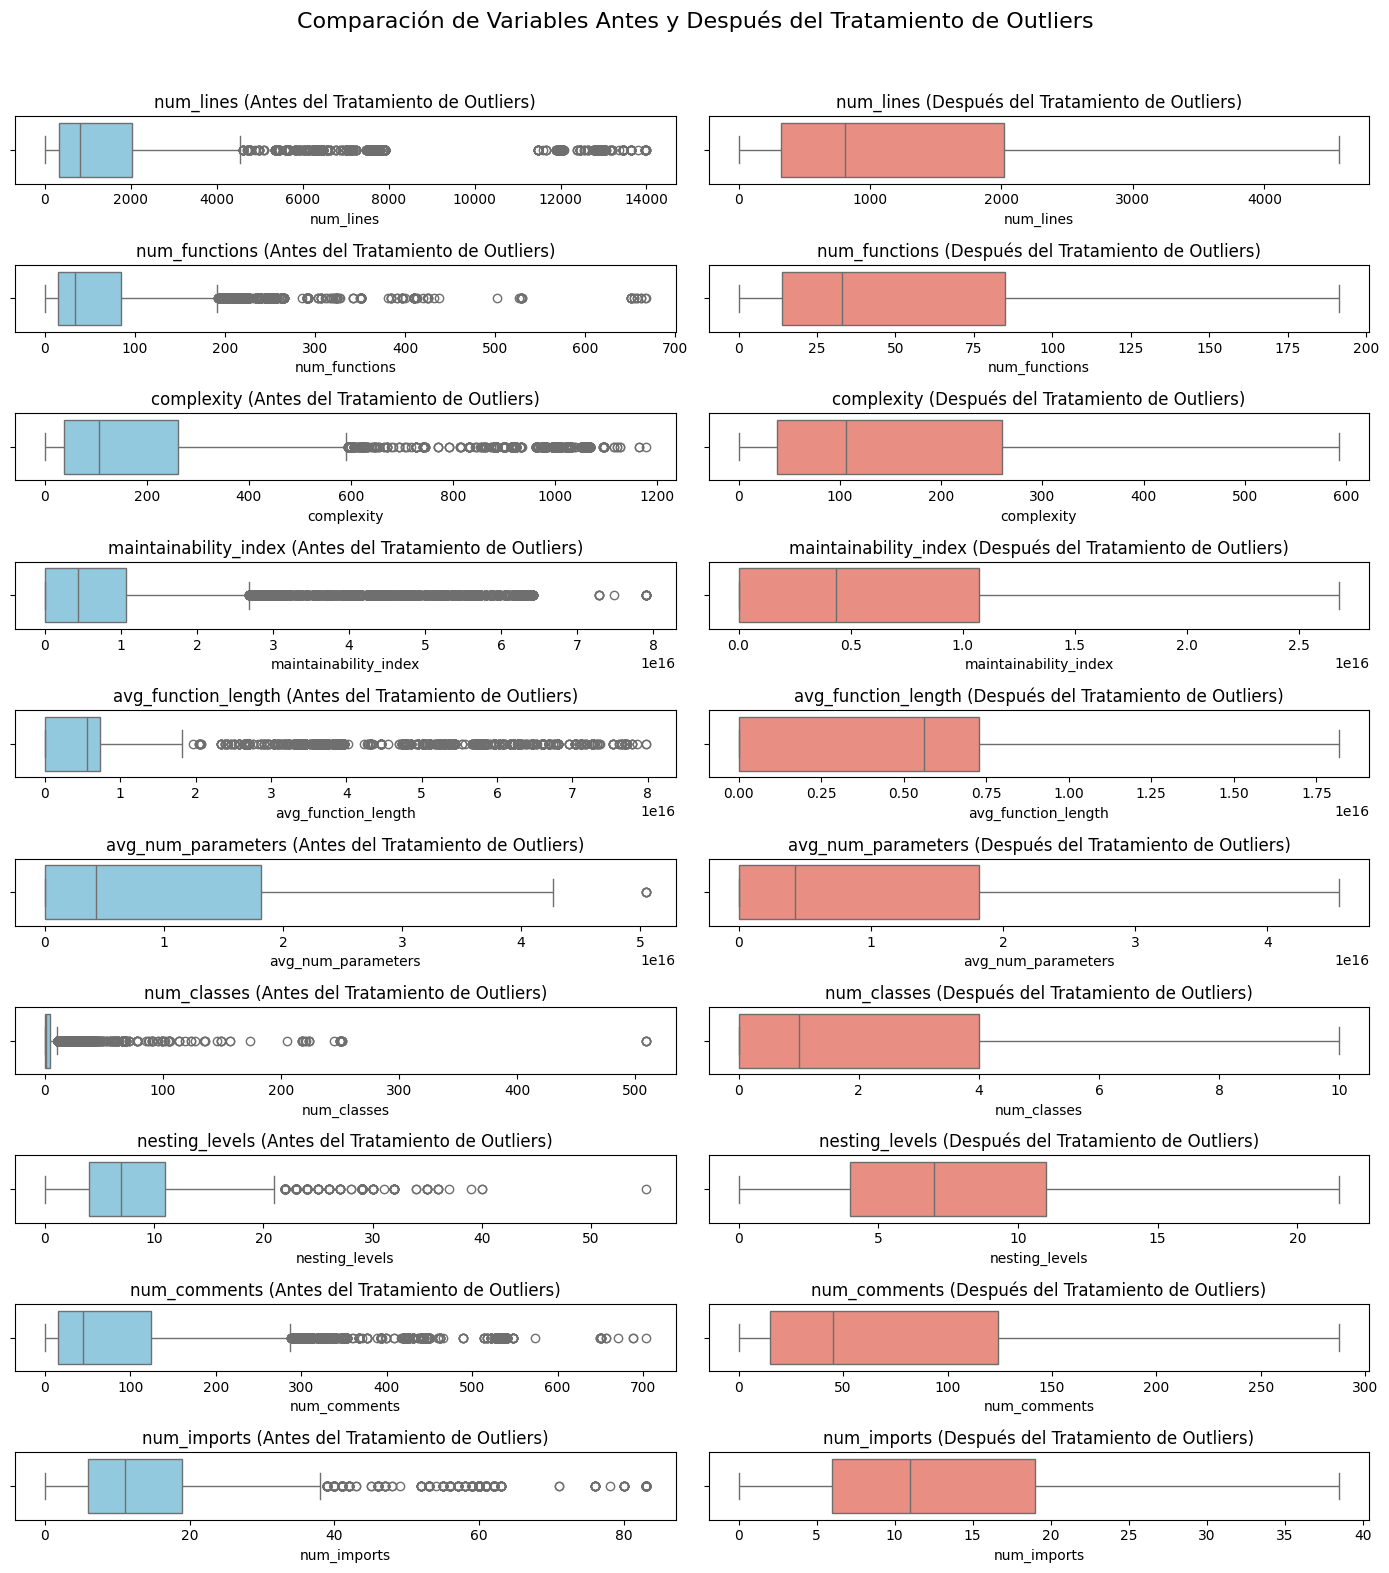

In [ ]:
# Gráficos de comparación antes y después del tratamiento de outliers
fig, axes = plt.subplots(len(variables_to_impute_outliers), 2, figsize=(14, 16))
fig.suptitle("Comparación de Variables Antes y Después del Tratamiento de Outliers", fontsize=16)

for i, feature in enumerate(variables_to_impute_outliers):
    # Gráfico antes del tratamiento
    sns.boxplot(data=df_original, x=feature, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"{feature} (Antes del Tratamiento de Outliers)")

    # Gráfico después del tratamiento
    sns.boxplot(data=df, x=feature, ax=axes[i, 1], color="salmon")
    axes[i, 1].set_title(f"{feature} (Después del Tratamiento de Outliers)")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

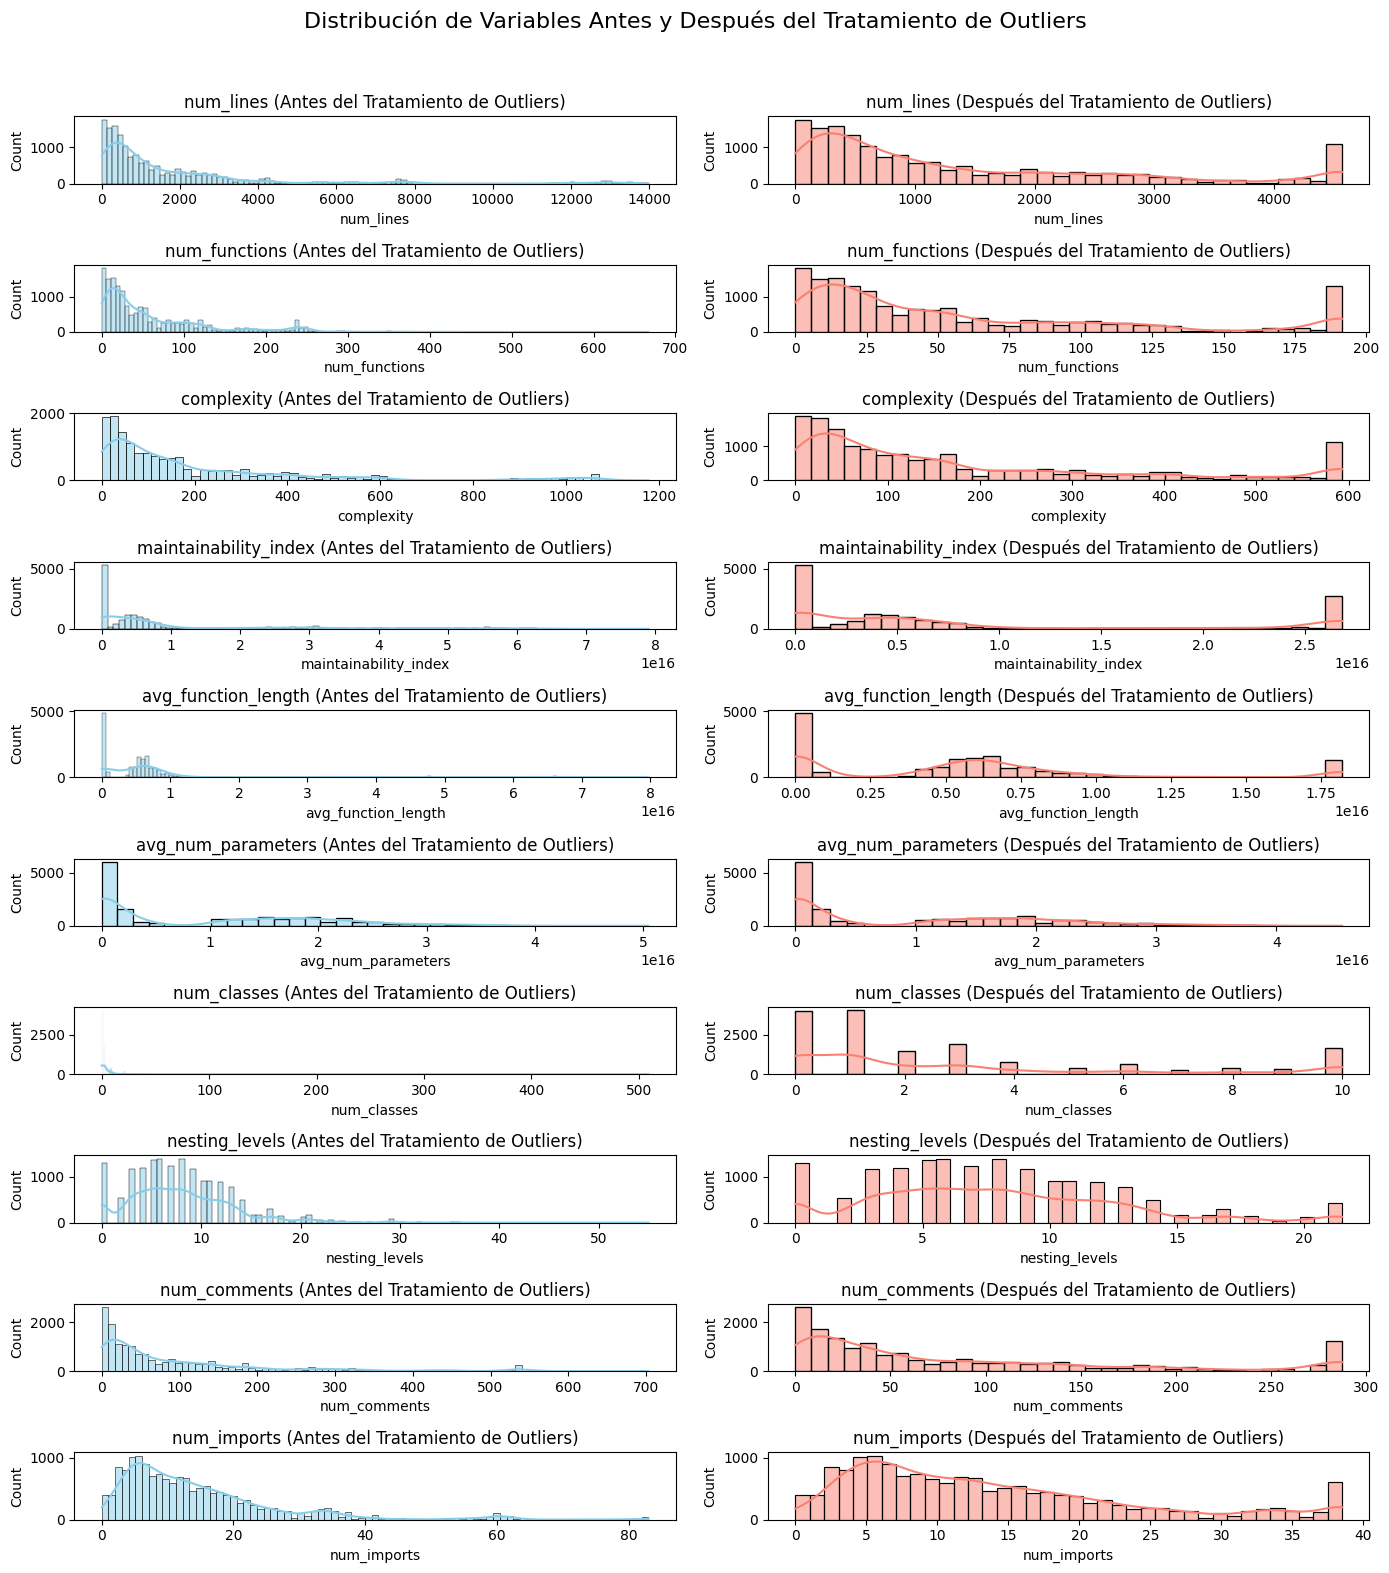

In [ ]:
# Gráficos de distribución (histogramas) antes y después del tratamiento
fig, axes = plt.subplots(len(variables_to_impute_outliers), 2, figsize=(14, 16))
fig.suptitle("Distribución de Variables Antes y Después del Tratamiento de Outliers", fontsize=16)

for i, feature in enumerate(variables_to_impute_outliers):
    # Histograma antes del tratamiento
    sns.histplot(df_original[feature], kde=True, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"{feature} (Antes del Tratamiento de Outliers)")

    # Histograma después del tratamiento
    sns.histplot(df[feature], kde=True, ax=axes[i, 1], color="salmon")
    axes[i, 1].set_title(f"{feature} (Después del Tratamiento de Outliers)")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#TRANSFORMACIÓN LOGARÍTMICA

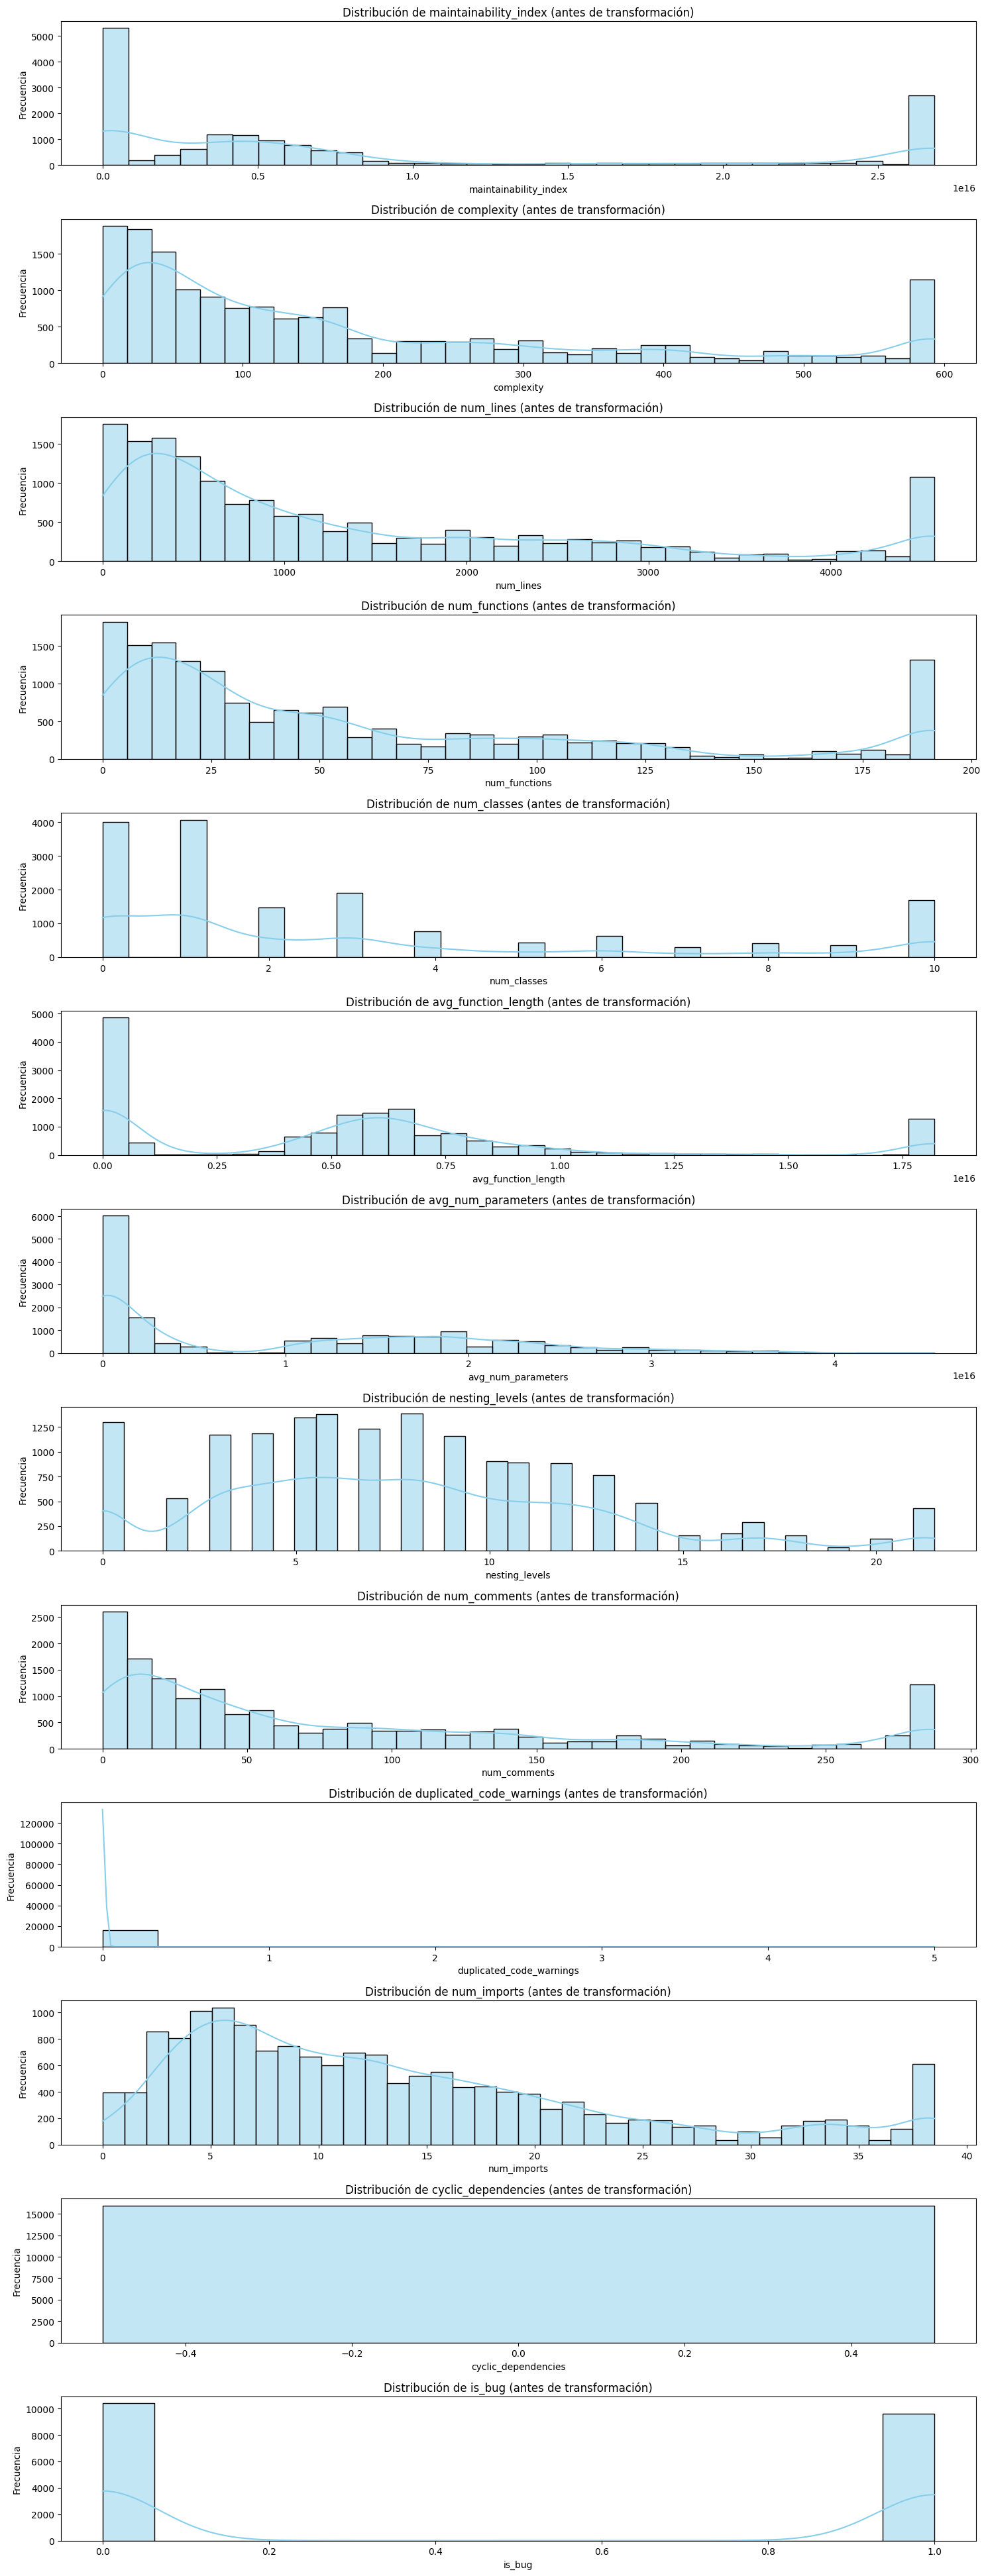

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar solo las columnas numéricas
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns

# Configurar el tamaño de la figura
plt.figure(figsize=(15, len(numeric_features) * 3))

# Graficar cada característica numérica
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(len(numeric_features), 1, i)
    sns.histplot(df[feature], kde=True, color='skyblue')
    plt.title(f'Distribución de {feature} (antes de transformación)')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


Distribución (Antes de Transformación): El primer gráfico muestra la distribución original de las variables numéricas. Este histograma sugiere una distribución sesgada a la derecha

In [ ]:
# Aplicar transformación logarítmica
df['complexity'] = np.log1p(df['complexity'])
df['num_lines'] = np.log1p(df['num_lines'])
df['num_functions'] = np.log1p(df['num_functions'])
df['maintainability_index'] = np.log1p(df['maintainability_index'])

df['num_classes'] = np.log1p(df['num_classes'])
df['nesting_levels'] = np.log1p(df['nesting_levels'])
df['num_comments'] = np.log1p(df['num_comments'])
df['num_imports'] = np.log1p(df['num_imports'])




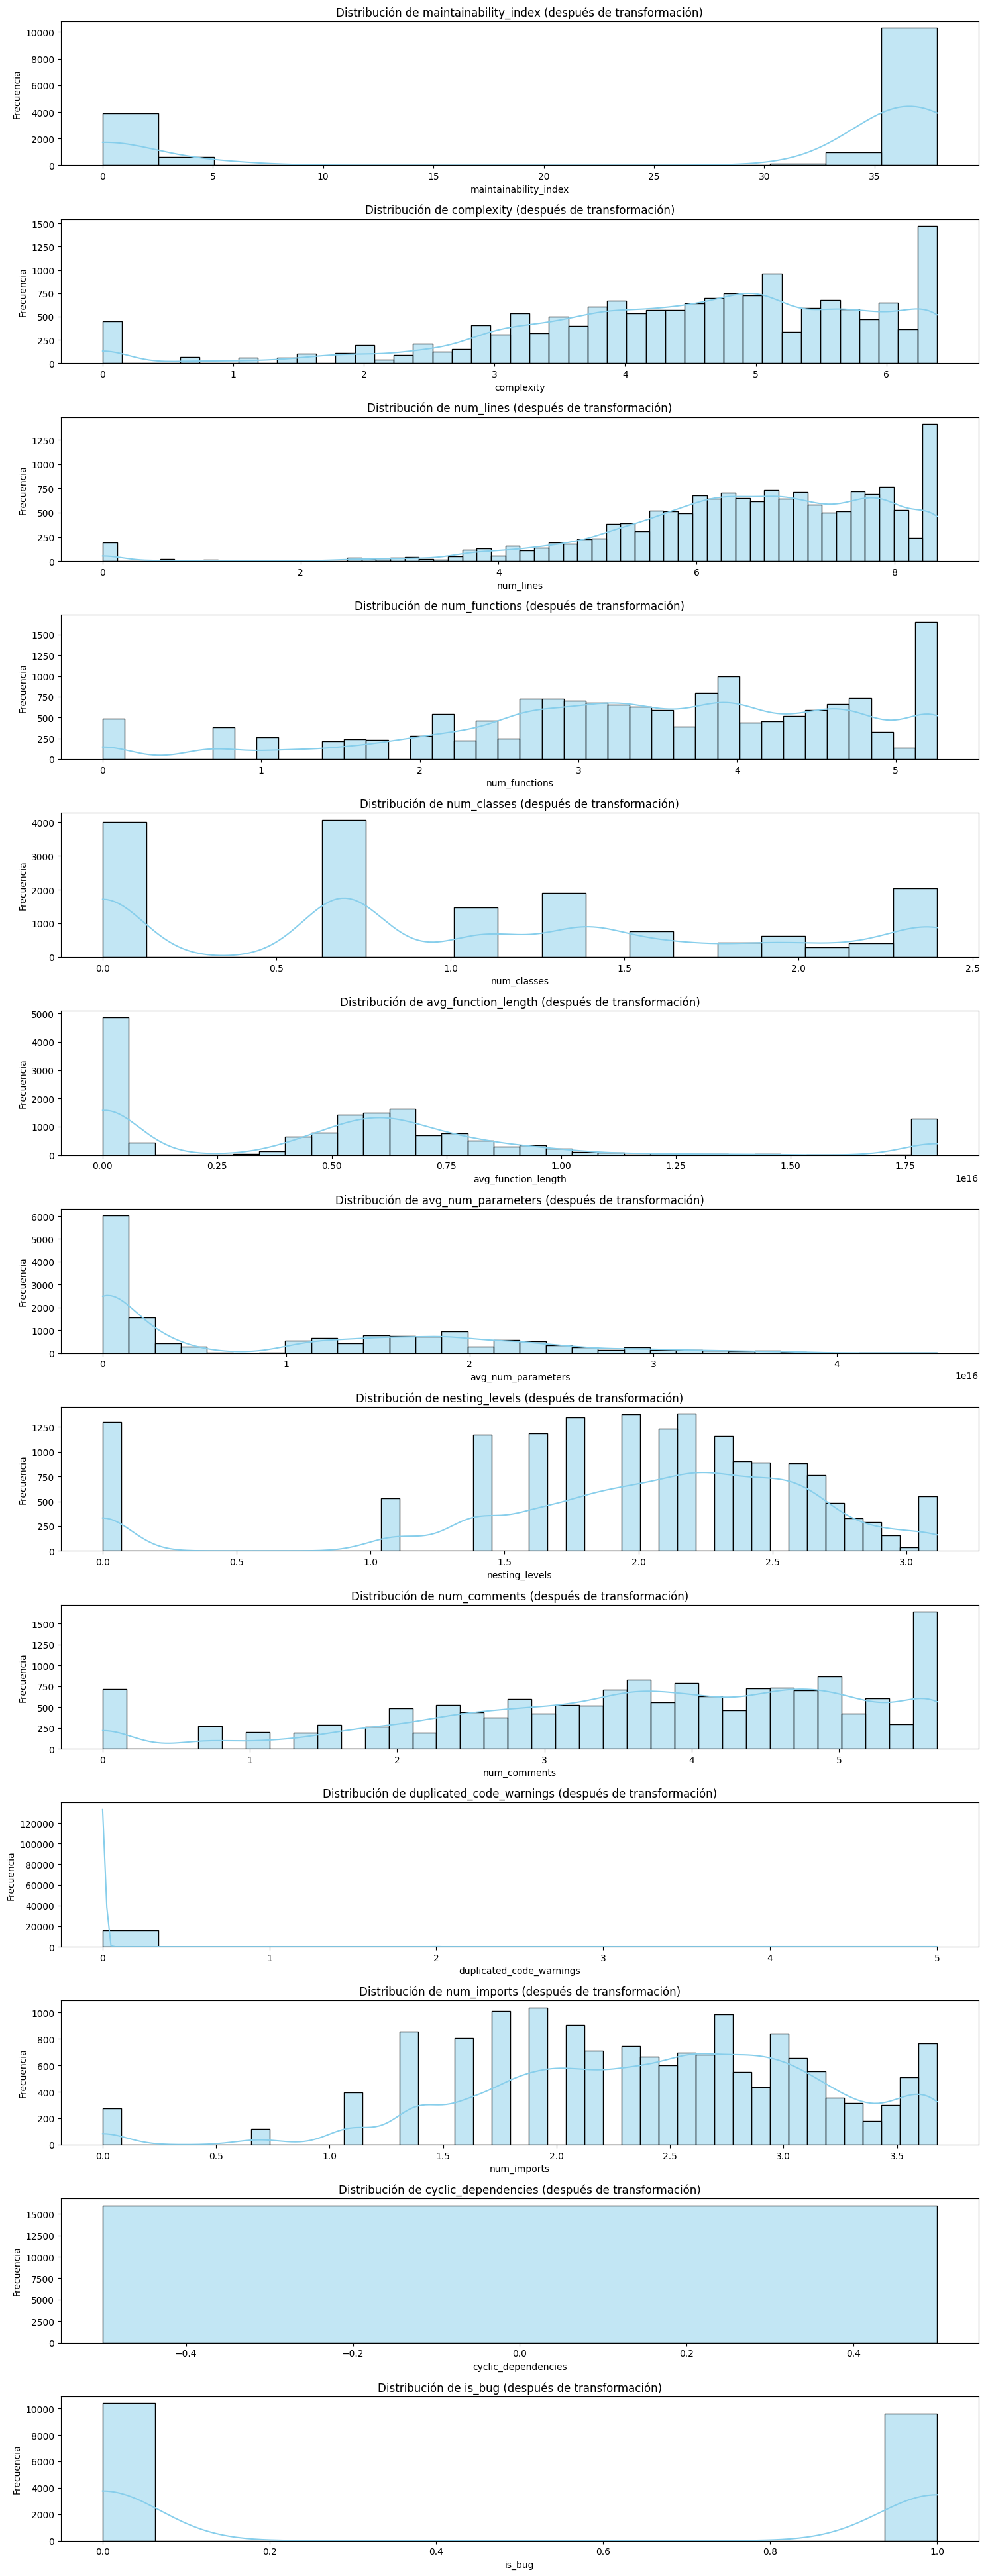

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar solo las columnas numéricas
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns

# Configurar el tamaño de la figura
plt.figure(figsize=(15, len(numeric_features) * 3))

# Graficar cada característica numérica
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(len(numeric_features), 1, i)
    sns.histplot(df[feature], kde=True, color='skyblue')
    plt.title(f'Distribución de {feature} (después de transformación)')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


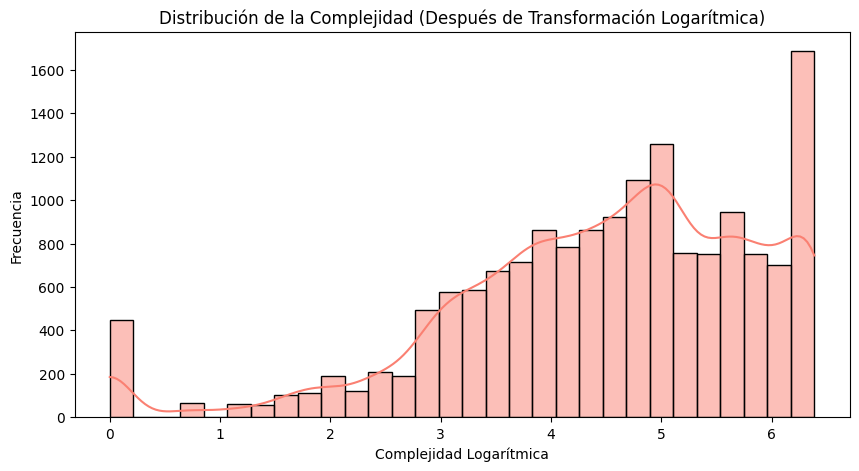

In [ ]:
# Histograma de la métrica de complejidad después de la transformación logarítmica
plt.figure(figsize=(10, 5))
sns.histplot(df['complexity'], bins=30, kde=True, color='salmon')
plt.title('Distribución de la Complejidad (Después de Transformación Logarítmica)')
plt.xlabel('Complejidad Logarítmica')
plt.ylabel('Frecuencia')
plt.show()

Distribución de la Complejidad (Después de Transformación Logarítmica): Este gráfico muestra la misma variable de complejidad después de aplicar una transformación logarítmica. Esta transformación ha ayudado a normalizar la distribución, lo cual es beneficioso para muchos modelos de machine learning, ya que una distribución más cercana a la normal tiende a mejorar la capacidad del modelo de capturar patrones en los datos.

#NORMALIZACIÓN

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

imputer = SimpleImputer(strategy='mean')

# Imputar valores nulos
df[['complexity', 'num_lines', 'num_functions']] = imputer.fit_transform(df[['complexity', 'num_lines', 'num_functions']])

# Verificar si hay valores nulos en bug_type y eliminarlos
if df['bug_type'].isnull().any():
  print("Existen valores nulos en 'bug_type'. Eliminando filas...")
  df = df.dropna(subset=['bug_type'])

# Codificar la variable bug_type
label_encoder = LabelEncoder()
df['bug_type'] = label_encoder.fit_transform(df['bug_type'])

# Variables predictoras y objetivo
imputer = SimpleImputer(strategy='mean')
X = df[['complexity', 'num_lines', 'num_functions', 'maintainability_index', 'num_classes',
        'avg_function_length', 'nesting_levels', 'num_imports', 'num_comments']]

column_names = X.columns

X = imputer.fit_transform(X)
y = df['bug_type']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Convertir de nuevo a DataFrame para facilidad de graficación


X_train_df = pd.DataFrame(X_train, columns=column_names)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=column_names)

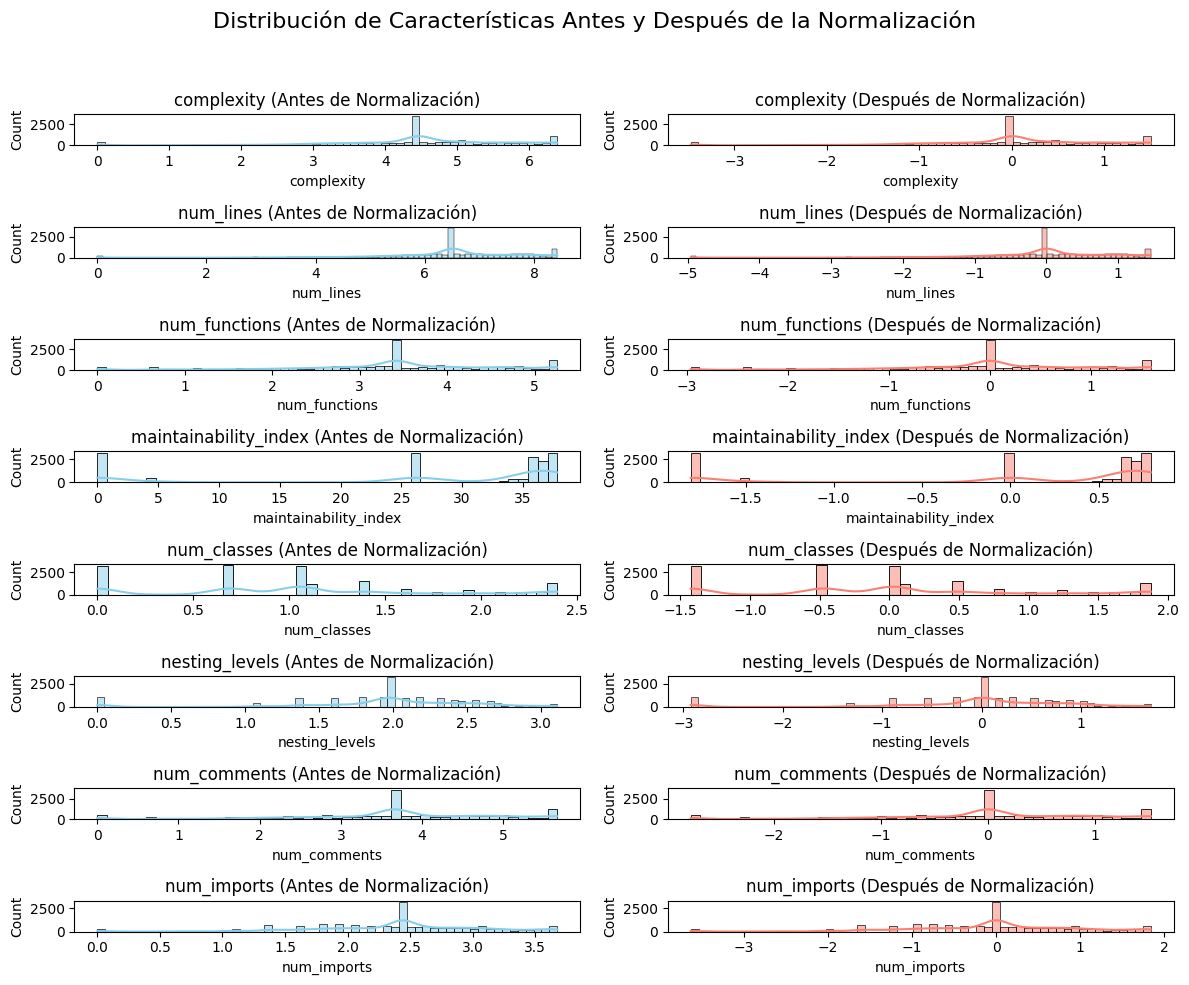

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

features = ['complexity', 'num_lines', 'num_functions', 'maintainability_index', 'num_classes', 'nesting_levels', 'num_comments', 'num_imports']

# Graficar antes y después de la normalización
fig, axes = plt.subplots(len(features), 2, figsize=(12, 10))
fig.suptitle("Distribución de Características Antes y Después de la Normalización", fontsize=16)

for i, feature in enumerate(features):
    # Gráfico antes de la normalización
    sns.histplot(X_train_df[feature], kde=True, color="skyblue", ax=axes[i, 0])
    axes[i, 0].set_title(f"{feature} (Antes de Normalización)")

    # Gráfico después de la normalización
    sns.histplot(X_train_scaled_df[feature], kde=True, color="salmon", ax=axes[i, 1])
    axes[i, 1].set_title(f"{feature} (Después de Normalización)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#BALANCEO

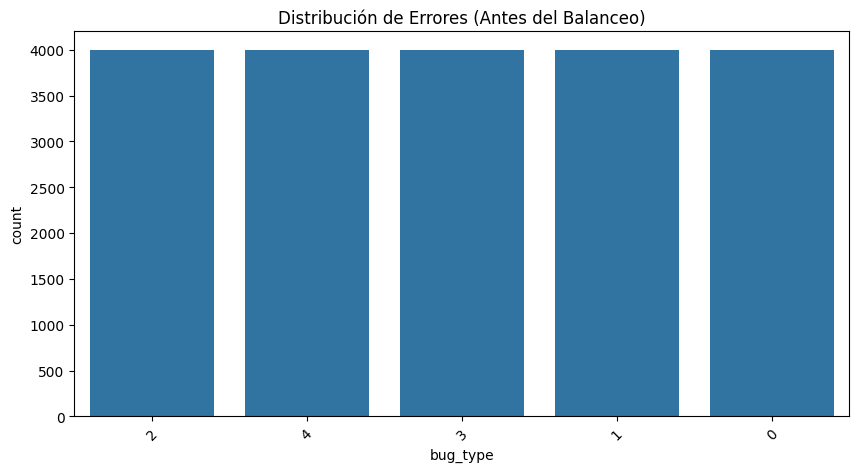

In [ ]:
# Distribución de clases de errores antes del balanceo
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='bug_type', order=df['bug_type'].value_counts().index)
plt.title('Distribución de Errores (Antes del Balanceo)')
plt.xticks(rotation=45)
plt.show()

Antes del Balanceo: La primera gráfica muestra un desequilibrio significativo en la frecuencia de los tipos de errores. Algunos tipos de errores, como el 4, aparecen con mucha más frecuencia que otros, lo que indica un desbalance en las clases del dataset original.



In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Imputar valores nulos en X
#imputer = SimpleImputer(strategy='mean')
#X_train_imputed = imputer.fit_transform(X_train)  # Imputa valores faltantes en X

# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y_train)

#OVERSAMPLING

smote = SMOTE(random_state=42, k_neighbors=2)
X_train_resampled, y_train_resampled  = smote.fit_resample(X_train_scaled, y_train)


#UNDERSAMPLING

undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)



In [ ]:
# Crear un DataFrame con los datos balanceados
df_train_resampled = pd.DataFrame(X_train_resampled, columns=column_names)
df_train_resampled['bug_type'] = label_encoder.inverse_transform(y_train_resampled)

In [ ]:
df_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16095 entries, 0 to 16094
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   complexity             16095 non-null  float64
 1   num_lines              16095 non-null  float64
 2   num_functions          16095 non-null  float64
 3   maintainability_index  16095 non-null  float64
 4   num_classes            16095 non-null  float64
 5   avg_function_length    16095 non-null  float64
 6   nesting_levels         16095 non-null  float64
 7   num_imports            16095 non-null  float64
 8   num_comments           16095 non-null  float64
 9   bug_type               16095 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.2+ MB


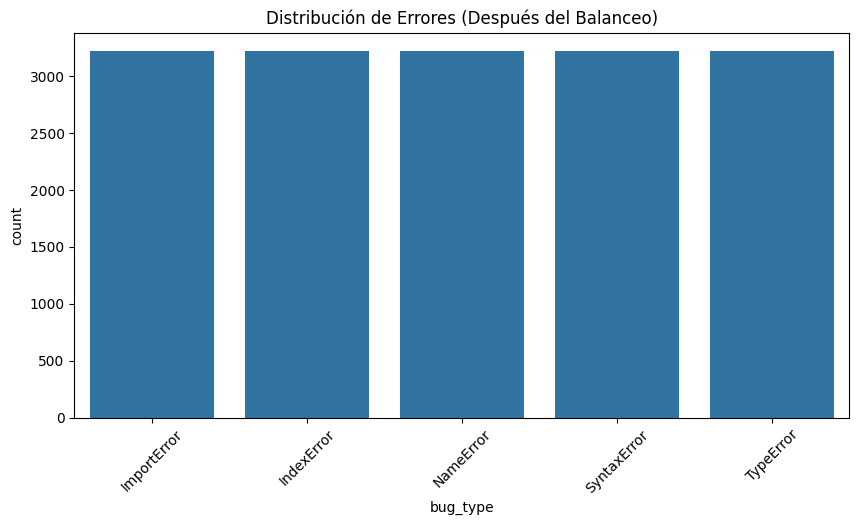

In [ ]:
# Distribución de clases de errores después del balanceo
plt.figure(figsize=(10, 5))
sns.countplot(data=df_train_resampled, x='bug_type', order=df_train_resampled['bug_type'].value_counts().index)
plt.title('Distribución de Errores (Después del Balanceo)')
plt.xticks(rotation=45)
plt.show()

Después del Balanceo: La segunda gráfica muestra una distribución equilibrada de los tipos de errores después de aplicar técnicas de balanceo (como SMOTE). Todos los tipos de errores tienen aproximadamente la misma frecuencia, lo que es ideal para que el modelo de clasificación no favorezca las clases mayoritarias y pueda aprender de todas las clases de errores de forma equitativa.

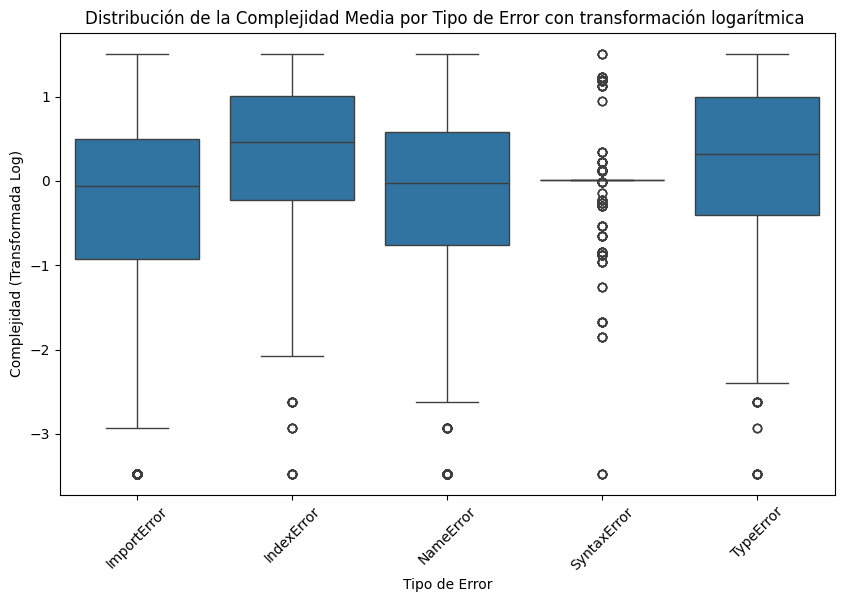

In [ ]:
# Distribución de la Complejidad Media por Tipo de Error
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train_resampled, x='bug_type', y='complexity')
plt.title('Distribución de la Complejidad Media por Tipo de Error con transformación logarítmica ')
plt.xticks(rotation=45)
plt.xlabel('Tipo de Error')
plt.ylabel('Complejidad (Transformada Log)')
plt.show()

# MODELO RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Ajustar los hiperparámetros del modelo usando RandomizedSearchCV

# Definir el rango de hiperparámetros a explorar
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Inicializar el modelo
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=50,  # Número de combinaciones a probar
                                   cv=3,  # Validación cruzada con 3 particiones
                                   verbose=2,  # Para obtener más detalles durante la ejecución
                                   random_state=42,
                                   n_jobs=-1,  # Utilizar todos los procesadores disponibles
                                   scoring='accuracy')
# Ajustar el modelo a los datos de entrenamiento
random_search.fit(X_train_resampled, y_train_resampled)
# Devolver los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search.best_params_}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores parámetros: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}


In [ ]:
# MEJOR MODELO

best_model = random_search.best_estimator_

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

# Predicciones
y_pred = best_model.predict(X_test_scaled)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Convertir las clases a cadenas para el reporte
target_names = label_encoder.classes_.astype(str)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.94325
F1 Score: 0.942891209853061
Precision: 0.944128454293888
Recall: 0.94325
Classification Report:
               precision    recall  f1-score   support

 ImportError       0.97      0.92      0.95       784
  IndexError       0.95      0.98      0.97       800
   NameError       0.96      0.89      0.93       781
 SyntaxError       0.91      1.00      0.96       809
   TypeError       0.93      0.91      0.92       826

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000

Confusion Matrix:
 [[725   5   0  54   0]
 [  6 788   0   0   6]
 [ 12  15 698   7  49]
 [  0   0   0 809   0]
 [  6  22  30  15 753]]


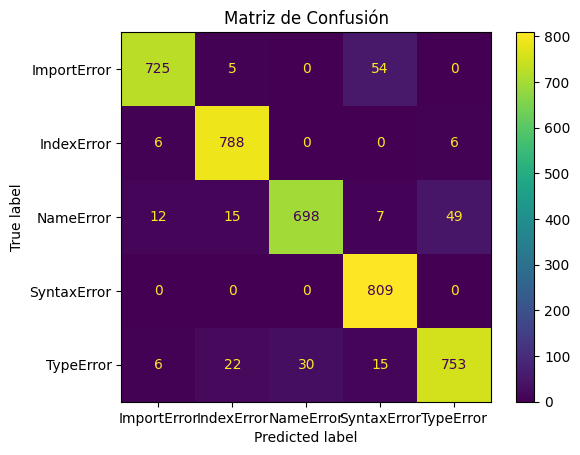

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test, display_labels=label_encoder.classes_)
plt.title("Matriz de Confusión")
plt.show()


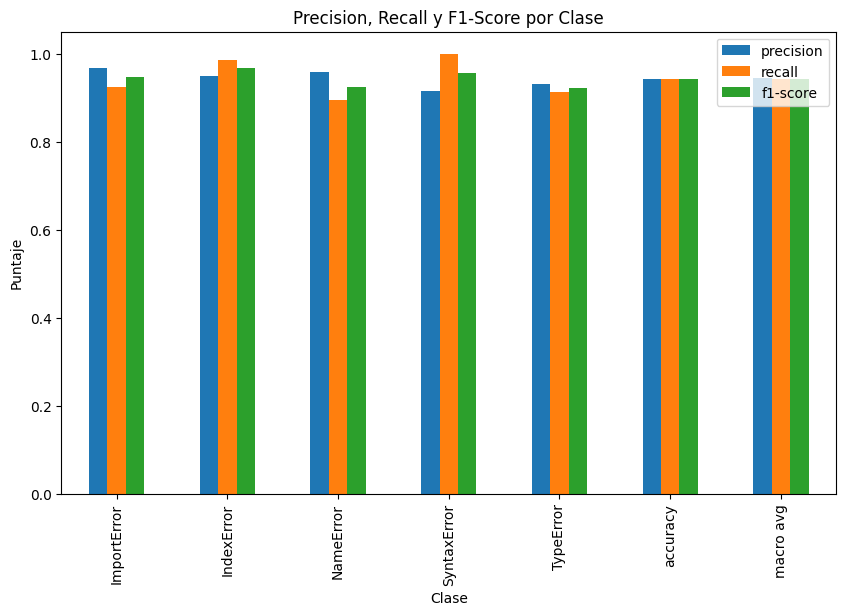

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report

# Generar reporte y convertir a DataFrame
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Graficar
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 6))
plt.title("Precision, Recall y F1-Score por Clase")
plt.ylabel("Puntaje")
plt.xlabel("Clase")
plt.show()


# MODELO XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# Definir el rango de hiperparámetros a explorar para XGBoost
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'scale_pos_weight': [1, 5, 10]  # Ajusta según el desbalance de clases
}

# Inicializar el modelo XGBoost
clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=50,  # Número de combinaciones a probar
                                   cv=3,  # Validación cruzada con 3 particiones
                                   verbose=2,  # Para obtener más detalles durante la ejecución
                                   random_state=42,
                                   n_jobs=-1,  # Utilizar todos los procesadores disponibles
                                   scoring='accuracy')

# Ajustar el modelo a los datos de entrenamiento
random_search.fit(X_train_resampled, y_train_resampled)

# Devolver los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search.best_params_}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:00:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores parámetros: {'subsample': 0.7, 'scale_pos_weight': 5, 'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.2, 'colsample_bytree': 0.5}


In [ ]:

# Utilizar el mejor modelo encontrado
best_model = random_search.best_estimator_


In [ ]:
# Predicciones
y_pred = best_model.predict(X_test_scaled)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Convertir las clases a cadenas para el reporte
target_names = label_encoder.classes_.astype(str)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.93475
F1 Score: 0.934249065890661
Precision: 0.935606150979782
Recall: 0.93475
Classification Report:
               precision    recall  f1-score   support

 ImportError       0.96      0.92      0.94       784
  IndexError       0.93      0.98      0.95       800
   NameError       0.96      0.88      0.92       781
 SyntaxError       0.92      1.00      0.96       809
   TypeError       0.91      0.89      0.90       826

    accuracy                           0.93      4000
   macro avg       0.94      0.93      0.93      4000
weighted avg       0.94      0.93      0.93      4000

Confusion Matrix:
 [[725   5   0  54   0]
 [ 10 782   0   0   8]
 [ 13  16 684   6  62]
 [  0   0   0 809   0]
 [ 10  35  28  14 739]]


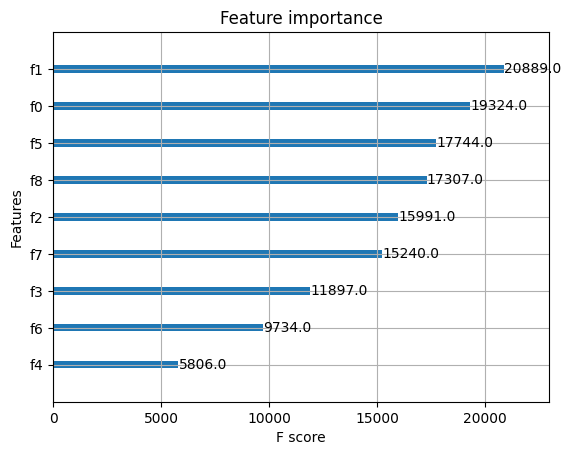

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(best_model)
plt.show()

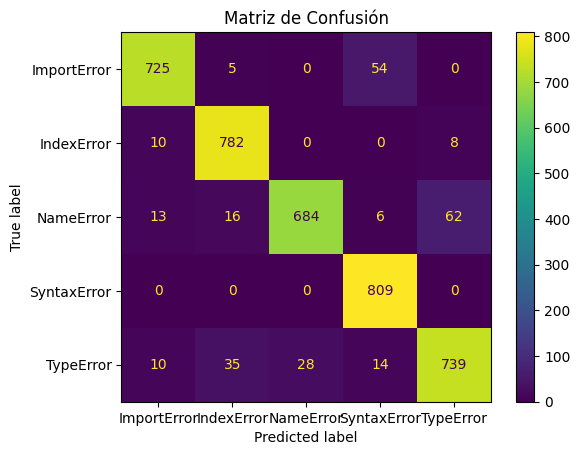

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test, display_labels=label_encoder.classes_)
plt.title("Matriz de Confusión")
plt.show()


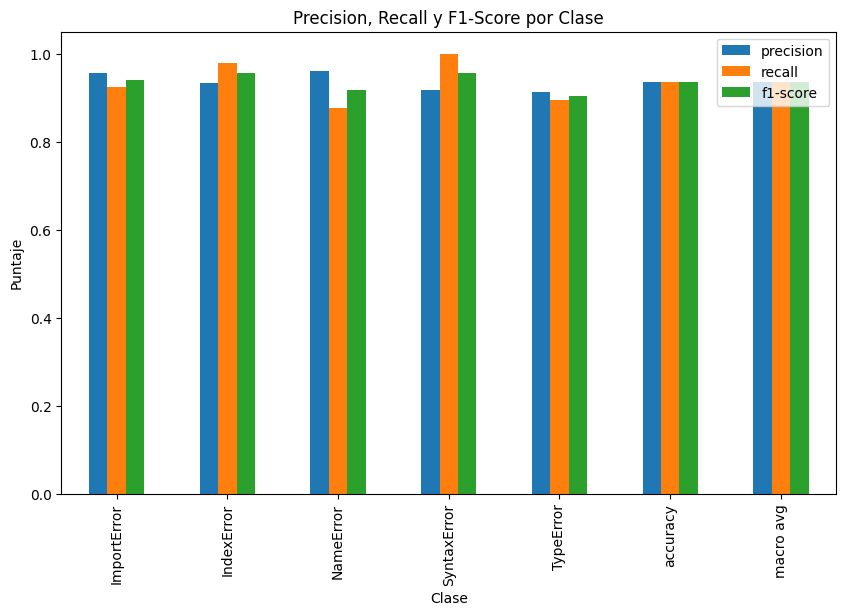

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report

# Generar reporte y convertir a DataFrame
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Graficar
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 6))
plt.title("Precision, Recall y F1-Score por Clase")
plt.ylabel("Puntaje")
plt.xlabel("Clase")
plt.show()


In [ ]:
# Crear un nuevo ejemplo de entrada
nuevo_ejemplo = pd.DataFrame({
    'complexity': [120],
    'num_lines': [1500],
    'num_functions': [15],
    'maintainability_index': [50],
    'num_classes': [3],
    'avg_function_length': [10],
    'nesting_levels': [2],
    'num_imports': [5],
    'num_comments': [20]
})

# Aplicar la transformación logarítmica
nuevo_ejemplo['complexity'] = np.log1p(nuevo_ejemplo['complexity'])
nuevo_ejemplo['num_lines'] = np.log1p(nuevo_ejemplo['num_lines'])
nuevo_ejemplo['num_functions'] = np.log1p(nuevo_ejemplo['num_functions'])
nuevo_ejemplo['maintainability_index'] = np.log1p(nuevo_ejemplo['maintainability_index'])

# Normalizar usando los mismos parámetros de entrenamiento
scaler = StandardScaler()
scaler.fit(X_train)  # Ajustar solo una vez en el conjunto de entrenamiento
nuevo_ejemplo_scaled = scaler.transform(nuevo_ejemplo)

# Hacer la predicción
prediccion = best_model.predict(nuevo_ejemplo_scaled)

# Decodificar la clase predicha a la etiqueta original
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
clase_predicha = label_encoder.inverse_transform(prediccion)

print("La clase de bug predicha es:", clase_predicha[0])

La clase de bug predicha es: 2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
print(label_encoder.classes_)  # Muestra las clases originales en el orden de la codificación


[0 1 2 3 4]


In [ ]:
# Decodifica una muestra de los valores en y_train
decoded_labels = label_encoder.inverse_transform([0, 1, 2, 3, 4])  # Reemplaza con valores según las clases que tienes
print(decoded_labels)


[0 1 2 3 4]
